<h1>Mushroom Image Classification Model</h1>

<h2>Introduction</h2>
Mushrooms constitute one of the largest living organisms on Earth. Funghi's applications are numerous: from degrading and breaking down natural waste to culinary applications. The latter is the focus of my research. Wild mushrooms that are readily available to keen foragers can be a delicious and nutritive addition to a meal.

However, the perennial question when encountering mushrooms in a forest or a field is: are these funghi edible or not? Apart from hallucinogenic properties, ingesting a poisonous mushroom can lead to severe hepatic pathologies and, in extreme cases, can also be fatal.

<h2>Background & Existing solutions</h2>
There are several applications that can identify the type of mushroom from an image taken by a user, for example [Mushroom Identificator](https://apps.apple.com/us/app/mushroom-identificator/id1227854971). These existing applications are carefully marketed as identification tools and will return a probability for edibility, however warning users to inform themselves further more before deciding whether or not eat the produce.

Moreover, there is a well-known Kaggle competition for predicting edibility but the [dataset](https://www.kaggle.com/uciml/mushroom-classification) consists of integer fields describing a fungus main features (cap-shape, colour, gills, etc).

Since I'm interested in how computer vision can contribute to this task, I will use an image dataset rather numerical-based, which I will scrape from a well-known domain-specific website, [Mushroom World](https://www.mushroom.world/home/index)

<h2>Goal</h2>
The purpose of this project is to develop an experimental Convolutional Neural Network to classify mushroom images towards an image recognition model that can predict whether or not a given mushroom is edible or not.

<h2>Methodology</h2>
A typical feature of classiflying mushroom is to break down its components, such as colour, cap, gills and stem much like CNN operate in processing different shapes, edges and colour. Therefore I will use a Convolutional Neural Network (CNN) model for a binary classification problem which will try to determine the edibility of a wild mushroom.

Needless to say, this model is purely developed for academic reasons and should not be used at all to actually decide whether or not to eat a wild mushroom.

<h2>Structure of report</h2>

The structure for this notebook is the following:

1.   Data Acquisition
2.   Exploratory Data Analysis
3.   Data pre-processing & re-scaling
4.   Data augmentation due to sample size
5.   Build a baseline model
6.   Beat baseline model, regularisation & overfitting model
7.   Model optimisation via hyperparameter tuning
8.   Results and final conclusions

<h2>1) Data Acquisition</h2>
I will create using a dataset available from Mushroom World. The dataset consists of: an image of a mushroom, a name field with the Latin denomination and a label for edibility. The edibility categories contains 7 possible labels: poisonous, edible, edible after cooking, etc. Since the main task is to predict if a funghi is edible or not I will bin those 7 labels into possible outcomes, Edible= True / False

In [ ]:
#Import libraries for scrapping data from Mushroom World
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import imageio

#Libraries for handling data
import pandas as pd
import numpy as np
import math

#Libraries for data visualisations
import matplotlib.pyplot as plt

#Tensorflow and Keras libraries
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Dropout, Flatten, Input
from keras.layers import BatchNormalization

#For reproducibility
#seed_val = 987
#np.random.seed(seed_val)


In [ ]:
#Acquiring mushroom dataset from Mushroom World
DATASET_VERSION = 'mushroom_world_2017_16_10'
DATASET_LINK = 'https://s3.eu-central-1.amazonaws.com/deep-shrooms/{}.zip'.format(DATASET_VERSION)

with urlopen(DATASET_LINK) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('./data')

In [ ]:
#Read data
DATASET_PATH = 'data/{}/'.format(DATASET_VERSION)

labels = pd.read_json(DATASET_PATH + 'mushroom_classes.json', lines=True)
images = pd.read_json(DATASET_PATH + 'mushroom_imgs.json', lines=True)
info = images.merge(labels, how = "right", on = "name_latin")

<h2>2) Exploratory Data Analysis</h2>

In [ ]:
#Let's have a look at what the data looks like as vectors
def load_mushroom_images(folder_path, img_df):
    img_dict = {}
    for index, path in enumerate(img_df['file_path']):
        img_dict[index] = imageio.imread(folder_path + path)
    return img_dict
        
img_dict = load_mushroom_images(DATASET_PATH, info)

#Print first row of dataset
print(img_dict[19])

[[[ 70  73  54]
  [143 148 128]
  [136 144 123]
  ...
  [ 14  12  26]
  [ 10   6  21]
  [ 29  22  38]]

 [[ 57  60  39]
  [135 140 118]
  [140 148 125]
  ...
  [  0   0  12]
  [  1   0  12]
  [ 28  24  39]]

 [[ 57  61  36]
  [132 138 112]
  [149 157 133]
  ...
  [ 13  11  24]
  [ 28  24  39]
  [ 45  41  56]]

 ...

 [[ 28  49  18]
  [ 18  39   6]
  [ 10  34   0]
  ...
  [ 27  45  21]
  [ 22  39  20]
  [ 19  33  18]]

 [[ 17  36   4]
  [ 18  37   5]
  [ 20  39   7]
  ...
  [ 16  31  10]
  [ 12  26  11]
  [ 11  23  13]]

 [[ 19  36   4]
  [  9  26   0]
  [  4  21   0]
  ...
  [ 11  24   7]
  [  7  19   9]
  [  6  17   9]]]


The dataset consists of 3D vectors. Next I will add padding to images to ensure all images have the same input shape: 480 x 480 pixels, stored in 3 RGB channels/ layers.

In [ ]:
#Print length of dataset. Dataset consists of 536 samples.
print(len(img_dict))

536


In [ ]:
#Add padding to images to ensure an input shape of 480,480,3
i = 0
for img in img_dict:
    if img_dict[img].shape != img_dict[0].shape:
        i = i + 1
        print(img_dict[img].shape)
        print(img)

for img in img_dict:
    height = 480 - img_dict[img].shape[0]
    width = 480 - img_dict[img].shape[1]

    if(height % 2 == 1 & width % 2 == 1):
        height1,height2 = math.floor(height/2), math.floor(height/2) + 1
        width1,width2 = math.floor(width/2), math.floor(width/2) +1
    elif(width % 2 == 1):
        width1,width2 = math.floor(width/2), math.floor(height/2) + 1
        height1,height2 = int(height/2), int(height/2)
    elif(height % 2 == 1):
        height1,height2 = math.floor(height/2), math.floor(height/2) + 1
        width1,width2 = int(width/2), int(width/2) 
    else:
        height1,height2 = int(height/2), int(height/2)
        width1,width2 = int(width/2), int(width/2)

    if(height == 0):
        img_dict[img] = np.lib.pad(img_dict[img], ((0,0),(width1, width2),(0,0)), 'edge')
    elif (width == 0):
        img_dict[img] = np.lib.pad(img_dict[img], ((height1, height2),(0,0),(0,0)), 'edge')
    else:
        img_dict[img] = np.lib.pad(img_dict[img], ((height1, height2),(width1, width2),(0,0)), 'edge')

(319, 480, 3)
10
(319, 480, 3)
11
(319, 480, 3)
12
(319, 480, 3)
13
(319, 480, 3)
14
(319, 480, 3)
17
(319, 480, 3)
18
(320, 480, 3)
55
(320, 480, 3)
56
(320, 480, 3)
57
(319, 480, 3)
58
(319, 480, 3)
59
(319, 480, 3)
60
(319, 480, 3)
105
(319, 480, 3)
106
(319, 480, 3)
107
(319, 480, 3)
108
(319, 480, 3)
112
(319, 480, 3)
113
(319, 480, 3)
114
(319, 480, 3)
115
(319, 480, 3)
116
(319, 480, 3)
120
(319, 480, 3)
121
(359, 480, 3)
148
(359, 480, 3)
155
(319, 480, 3)
159
(319, 480, 3)
160
(319, 480, 3)
161
(319, 480, 3)
162
(319, 480, 3)
172
(319, 480, 3)
173
(319, 480, 3)
174
(319, 480, 3)
175
(319, 480, 3)
176
(319, 480, 3)
177
(319, 480, 3)
178
(319, 480, 3)
179
(319, 480, 3)
180
(319, 480, 3)
189
(319, 480, 3)
190
(319, 480, 3)
191
(319, 480, 3)
192
(319, 480, 3)
193
(319, 480, 3)
194
(319, 480, 3)
195
(319, 480, 3)
196
(319, 480, 3)
197
(319, 480, 3)
198
(319, 480, 3)
199
(319, 480, 3)
211
(319, 480, 3)
215
(319, 480, 3)
231
(319, 480, 3)
232
(319, 480, 3)
233
(319, 480, 3)
234
(319,

In [ ]:
#Function for visualizing a random sample
def draw_im(i, image_data=img_dict, label_data=info):
    name = label_data.iloc[i].name_latin
    edibility = label_data.iloc[i].edibility
    url = label_data.iloc[i].img_url
    x = image_data[i]
    plt.imshow(x)
    plt.title( name + ": " + edibility)
    plt.show()

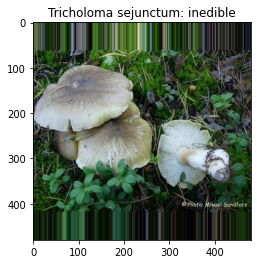

In [ ]:
draw_im(19)

As it can be observed, the sample 19 is called Tricholoma sejunctum, is inedible and the image has been re-shaped to meet the 480x480 shape.

So far I have managed to read in data, explore the original image shapes and then standardize them all to be the same shape.

Next I will re-group the Edibility categories from 7 possible values to a binary field.

In [ ]:
#Check labels to see how many classes are available in dataset
labels.edibility.value_counts()

inedible                49
edible                  32
poisonous               16
edible and good         11
edible and excellent     6
lethally poisonous       5
edible when cooked       3
Name: edibility, dtype: int64

###Dataset contains 7 classes. I will group the classes in 2 supra-categories: edible and inedible. The reason why I do this: a) simplify model and frame this as a binary classification problem; b) increase the sample count for classes, since the original distribution

<h2>3) Data pre-processing & re-scaling</h2>

In [ ]:
class_labels = info.edibility.isin(("edible", "edible and good", "edible and excellent"))

X = []
y = []

for i in range(len(class_labels)):
    if(img_dict[i].shape == (480,480,3)):
        y.append(class_labels[i])
        X.append(img_dict[i])


X = np.stack(X)
y = pd.Series(y)

print(X.shape)
print(y.shape)

(536, 480, 480, 3)
(536,)


In [ ]:
#check the data type
X.dtype

dtype('uint8')

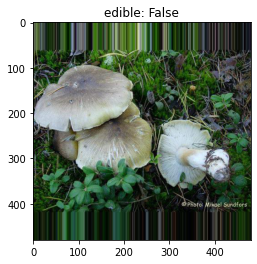

In [ ]:
def draw_im2(i, X, y):
    plt.imshow(X[i])
    plt.title("edible: " + str(y[i]))
    plt.show()

draw_im2(19, X, y)

As a recap, I have turned 7 classes into binary possibility (edible_yes, edible_no) and created 2 variables for storing images and labels. Next I will move on to data augmentation in order to generate more images using ImageDataGenerator library to increase sample size.

Given the small size of the dataset (only 536 samples), I will proceed to augment the dataset using ImageDataGenerator (IDG) Library. Using IDG, as Yann Le Cunn has stated, is a necessary and temporary fix for expanding datasets for now.

<h2>4) Data augmentation due to sample size</h2>

In [ ]:
#Generate more images using ImageDataGenerator library to increase sample size.
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest') #this fill mode takes the closest pixel to edge and expands: AAAABCDDDDD

test_datagen = ImageDataGenerator()

In [ ]:
#Inspect split between edible and not edible counts in the dataset
y.value_counts()

False    310
True     226
dtype: int64

In [ ]:
#Rescaling images to 255 and specifying data type to float32 for efficient computing
X = X.astype("float32")/255

#Assign 20% of dataset for training
N = len(X)
N_tr = int(0.8*N)

#Shuffle the data
indx = np.arange(N)
np.random.shuffle(indx)
X = X[indx]
y = y[indx]

# split
X_tr = X[0:N_tr]
y_tr = y[0:N_tr]

X_te = X[N_tr:]
y_te = y[N_tr:]

In [ ]:
input_shape=X[0].shape

<h2>5) Creating a Baseline Model</h2>
I will use the package Dummy Classifier from Sklearn to generate a naive first model that classifies targets at random.

In [ ]:
#create a baseline model
from sklearn.dummy import DummyClassifier
baseline_model=DummyClassifier().fit(X_tr, y_tr)
baseline_model.score(X_te, y_te)

0.5925925925925926

A Dummy Classifier returned a score of 55%. This is my baseline score, which I will seek to beat.

<h2>6) Beating the baseline model & Regularisation</h2>

<h2>Initial Model Neural Network Architecture with Regularisation</h2>
Let's look at the first model summary in more detail:

*   The model takes an input shape of 480 x 480 with 3 channels (RGB) from the dataset
*   The model receives 480×480 images as input, then has a sequence of two convolutional and pooling layers as feature extractors, followed by a fully connected layer to interpret the features and an output layer with a sigmoid activation for two-class predictions.
*   The first Conv2D layer slightly compresses the input shape (from 480 to 477) by applying 16 filters with 476 being the shape of the output that will feed the next layer. The model consists of 2 2D Convolutional layers which are then flattened and then connect to a dense or fully-connnected layer with 128 nodes and finally an output  layer of 1 node for the binary classification. With each Conv layer, the amount of input data reduces (476 > 234 > 117, etc) whilst the number of parameters increases till we get to a total of 56 million parameters that are processed by the network. The goal is to extract the most important features of the image for the training process. I'm also setting the kernel size at 5.
*   I am also adding a BatchNormalization command since it allows for a transformation that maintains the mean output close to 0 and the output standard deviation close to 1. In theory, BatchNormalization stabilizes the learning process and requires less number of epochs. Since I'm starting with 10 epochs, I will use BN for an initial model.
*   In terms of regularisation, I'm adding a dropout rate of 0.3 for the fully connected layer, just before the output layer

As a methodological note, I'm employing Functional API programming in my approach. Functional API programming is normally used for model with multiple inputs and outputs - which is not the case here, but it's a very easy approach to use.



In [ ]:
#Creating a 2D Convolutional Neural Network Model using functional API
visible = Input(shape=(480,480,3))
conv1 = Conv2D(16, kernel_size=5, use_bias=False)(visible)
conv1 = BatchNormalization()(conv1)
conv1 = Activation("relu")(conv1) #activation needs to come after BatchNormalization
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(32, kernel_size=5, use_bias=False)(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation("relu")(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flat = Flatten()(pool2)
hidden1 = Dense(128, activation='relu')(flat)
dropout = Dropout(0.3)(hidden1)
output = Dense(1, activation='sigmoid')(dropout) #using sigmoid for last layer since it's a binary classification
model = Model(inputs=visible, outputs=output)
# summarize layers
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 476, 476, 16)      1200      
                                                                 
 batch_normalization (BatchN  (None, 476, 476, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 476, 476, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 238, 238, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 234, 234, 32)      12800 

In [ ]:
# Defining hyperparameters for model with optimizer, the type of loss is binary crossentropy
# because the model output is a binary classification (edible/ not edible)
#Using RMSprop as optimizer because it has an adaptive learning rate that adapts to the learning process
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['accuracy'])

In [ ]:
#Run model setting the batch_size to 64 and with 10 epochs
history = model.fit(train_datagen.flow(X_tr, y_tr, batch_size = 64),
                    validation_data = test_datagen.flow(X_te, y_te, batch_size = 64),
                    steps_per_epoch= len(X_tr) / 64, 
                    validation_steps = len(X_te) /64,
                    epochs = 10, verbose = 1)

Epoch 1/10
6/6 [==============================] - 105s 15s/step - loss: 316.5000 - accuracy: 0.5514 - val_loss: 46.5699 - val_accuracy: 0.4074
Epoch 2/10
6/6 [==============================] - 100s 15s/step - loss: 31.2787 - accuracy: 0.5140 - val_loss: 11.2249 - val_accuracy: 0.5833
Epoch 3/10
6/6 [==============================] - 99s 15s/step - loss: 14.6515 - accuracy: 0.5164 - val_loss: 0.7796 - val_accuracy: 0.5648
Epoch 4/10
6/6 [==============================] - 106s 17s/step - loss: 1.3889 - accuracy: 0.4813 - val_loss: 0.6836 - val_accuracy: 0.5278
Epoch 5/10
6/6 [==============================] - 100s 15s/step - loss: 0.7169 - accuracy: 0.5654 - val_loss: 0.7032 - val_accuracy: 0.3611
Epoch 6/10
6/6 [==============================] - 100s 15s/step - loss: 0.9604 - accuracy: 0.5584 - val_loss: 0.7579 - val_accuracy: 0.5185
Epoch 7/10
6/6 [==============================] - 100s 15s/step - loss: 0.7046 - accuracy: 0.5607 - val_loss: 0.6931 - val_accuracy: 0.5741
Epoch 8/10
6/6 

In [ ]:
#Creates a history dictionary for plotting results
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

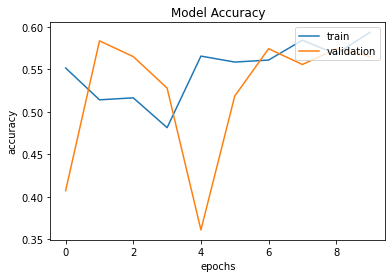

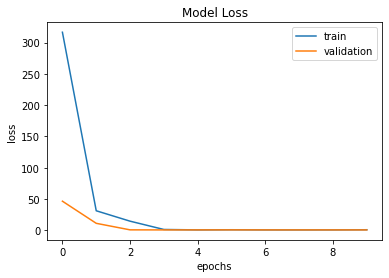

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

The loss function shows a peculiar behaviour by starting with very high values (316) and then sharply decreasing in the next 2 epochs to values between 0.9 and 0.7 but showing a flat line thereafter and with little differentiation from the validation curve. It seems strange that in the first epoch the model registers a very high loss and then drops abruptly, thus skewing the range.It could be that there is not enough data or that the model cannot learn properly with such few passes (epochs). So next I will increase number of epochs to give the model a chance to spread out the learning through more 'passes' (epochs) of the data.


In [ ]:
#Evaluate model's prediction
test_loss, test_acc = model.evaluate(X_te, y_te)

4/4 [==============================] - 5s 1s/step - loss: 0.6959 - accuracy: 0.5648


The first iteration of the model is not much better than the Dummy Classifier, it shows 56% of accuracy (vs. 55%).

<h2> Improvements to the model</h2>
For the next iteration, I will do the following tweaks:

*   Increase number of filters in CNN (from 16 to 32)
*   Increase number of nodes in the fully connected layer (from 128 to 256)
*   Remove BatchNormalization to observe if the loss function issue improves





In [ ]:
#Creating a 2D Convolutional Neural Network Model using functional API
visible = Input(shape=(480,480,3))
conv1 = Conv2D(32, kernel_size=5, activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(32, kernel_size=5, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flat = Flatten()(pool2)
hidden1 = Dense(256, activation='relu')(flat)
dropout = Dropout(0.3)(hidden1)
output = Dense(1, activation='sigmoid')(dropout) #using sigmoid for last layer since it's a binary classification
model = Model(inputs=visible, outputs=output)
# summarize layers
print(model.summary())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 476, 476, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 238, 238, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 234, 234, 32)      25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 117, 117, 32)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 438048)            0   

In [ ]:
# Defining hyperparameters for model with optimizer, the type of loss is binary crossentropy
# because the model output is a binary classification (edible/ not edible)
#Using RMSprop as optimizer because it has an adaptive learning rate that adapts to the learning process
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['accuracy'])

In [ ]:
#Running first iteration of the model
history = model.fit(train_datagen.flow(X_tr, y_tr, batch_size = 32),
                    validation_data = test_datagen.flow(X_te, y_te, batch_size = 32),
                    steps_per_epoch= len(X_tr) / 32, 
                    validation_steps = len(X_te) /32,
                    epochs = 10, verbose = 1)

Epoch 1/10
13/13 [==============================] - 36s 2s/step - loss: 20.7496 - accuracy: 0.5584 - val_loss: 0.6741 - val_accuracy: 0.5648
Epoch 2/10
13/13 [==============================] - 21s 2s/step - loss: 0.6848 - accuracy: 0.5818 - val_loss: 0.6734 - val_accuracy: 0.5648
Epoch 3/10
13/13 [==============================] - 21s 2s/step - loss: 0.6884 - accuracy: 0.5654 - val_loss: 0.6718 - val_accuracy: 0.5648
Epoch 4/10
13/13 [==============================] - 21s 2s/step - loss: 0.6892 - accuracy: 0.5607 - val_loss: 0.7401 - val_accuracy: 0.5648
Epoch 5/10
13/13 [==============================] - 21s 2s/step - loss: 0.6909 - accuracy: 0.5514 - val_loss: 0.6859 - val_accuracy: 0.6019
Epoch 6/10
13/13 [==============================] - 21s 2s/step - loss: 0.6861 - accuracy: 0.5748 - val_loss: 0.6845 - val_accuracy: 0.6296
Epoch 7/10
13/13 [==============================] - 21s 2s/step - loss: 0.6993 - accuracy: 0.5678 - val_loss: 0.6863 - val_accuracy: 0.5741
Epoch 8/10
13/13 [=

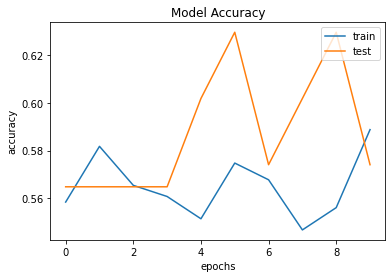

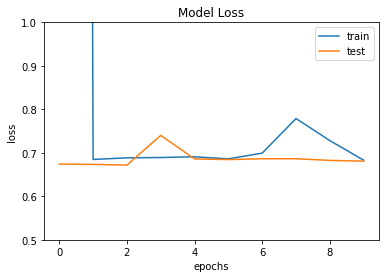

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.ylim([0.5, 1])
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
#Evaluate model's prediction
test_loss, test_acc = model.evaluate(X_te, y_te)

4/4 [==============================] - 11s 2s/step - loss: 0.6745 - accuracy: 0.6296


<h2>Iterated Model</h2>The second run of the model achieved 0.62 accuracy which is a considerate improvement from the baseline model. The most notable behaviour when analyzing the loss function graph is that in the first epoch the loss is still significantly higher (20.74) and then reduces abruptly to a range between 0.8 and 0.7. This is a drop in the loss function by removing BatchNormalization.

With 10 epochs the model does not seem to have enough opportunity for decreasing the loss function in a consisting way, so I will add more epochs to the model to allow for a longer learning process.

In [ ]:
#configuring optimizer, loss and metric
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['accuracy'])

In [ ]:
#Running same model as above but with 100 epochs instead of 10
history = model.fit(train_datagen.flow(X_tr, y_tr, batch_size = 64),
                    validation_data = test_datagen.flow(X_te, y_te, batch_size = 64),
                    steps_per_epoch= len(X_tr) / 64, 
                    validation_steps = len(X_te) /64,
                    epochs = 100, verbose = 1)

Epoch 1/100
6/6 [==============================] - 29s 3s/step - loss: 40.9975 - accuracy: 0.4883 - val_loss: 0.6709 - val_accuracy: 0.6019
Epoch 2/100
6/6 [==============================] - 20s 3s/step - loss: 0.6943 - accuracy: 0.5584 - val_loss: 0.6783 - val_accuracy: 0.6019
Epoch 3/100
6/6 [==============================] - 20s 3s/step - loss: 0.6839 - accuracy: 0.5654 - val_loss: 0.6785 - val_accuracy: 0.6389
Epoch 4/100
6/6 [==============================] - 20s 3s/step - loss: 0.7362 - accuracy: 0.5678 - val_loss: 1.3861 - val_accuracy: 0.5926
Epoch 5/100
6/6 [==============================] - 22s 3s/step - loss: 0.8010 - accuracy: 0.4953 - val_loss: 0.6921 - val_accuracy: 0.6481
Epoch 6/100
6/6 [==============================] - 20s 3s/step - loss: 0.6920 - accuracy: 0.5678 - val_loss: 0.6906 - val_accuracy: 0.6389
Epoch 7/100
6/6 [==============================] - 20s 3s/step - loss: 0.6907 - accuracy: 0.5771 - val_loss: 0.6889 - val_accuracy: 0.6019
Epoch 8/100
6/6 [=========

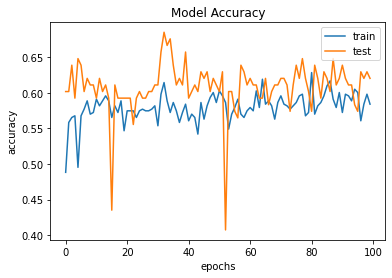

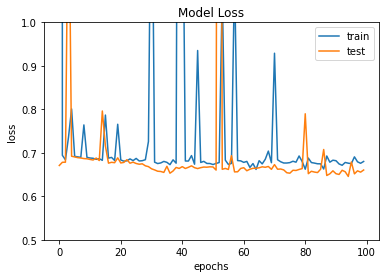

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.ylim([0.5, 1])
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
#Evaluate model's prediction
test_loss, test_acc = model.evaluate(X_te, y_te)

4/4 [==============================] - 2s 242ms/step - loss: 0.6605 - accuracy: 0.6204


Increasing the number of epochs had a small impact in the overall accuracy but more importantly I still observe that the loss function stays within a range, instead of decreasing over time. I will continue to optimize the model in order to reduce the loss function over time.

<h2>Iterations of Model</h2>
Following the universal workflow of a machine learning project, I will next attempt to create an overfitting model. The next iteration of the model receives 480×480 images as input, then has a sequence of two convolutional and pooling layers as feature extractors, followed by a fully connected layer to interpret the features and an output layer with a sigmoid activation for two-class predictions. I am increasing the number of filters in the CNN as well as the number of nodes in the dense layer.

In [ ]:
#Creating a 3D Convolutional Neural Network Model - aka Model2, and including strides as argument to reduce the number of parameters
visible = Input(shape=(480,480,3))
conv1 = Conv2D(32, kernel_size=(5,5), activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(5,5), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flat = Flatten()(pool2)
hidden1 = Dense(256, activation='relu')(flat)
hidden1 = Dropout(0.4)(hidden1)
output = Dense(1, activation='softmax')(hidden1)
model4 = Model(inputs=visible, outputs=output)
# summarize layers
print(model4.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 476, 476, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 238, 238, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 234, 234, 64)      51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 117, 117, 64)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 876096)            0   

In [ ]:
#Configuring new model with tweaked learning rate and using Adam instead of RMSProp
model4.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
history = model4.fit(train_datagen.flow(X_tr, y_tr, batch_size = 32),
                    validation_data = test_datagen.flow(X_te, y_te, batch_size = 32),
                    steps_per_epoch= len(X_tr) / 32, 
                    validation_steps = len(X_te) /32,
                    epochs = 100, verbose = 1)

Epoch 1/100
13/13 [==============================] - 197s 15s/step - loss: 0.0000e+00 - accuracy: 0.4252 - val_loss: 0.0000e+00 - val_accuracy: 0.4074
Epoch 2/100
13/13 [==============================] - 198s 15s/step - loss: 0.0000e+00 - accuracy: 0.4252 - val_loss: 0.0000e+00 - val_accuracy: 0.4074
Epoch 3/100
13/13 [==============================] - 211s 16s/step - loss: 0.0000e+00 - accuracy: 0.4252 - val_loss: 0.0000e+00 - val_accuracy: 0.4074
Epoch 4/100
13/13 [==============================] - 203s 15s/step - loss: 0.0000e+00 - accuracy: 0.4252 - val_loss: 0.0000e+00 - val_accuracy: 0.4074
Epoch 5/100
13/13 [==============================] - 207s 16s/step - loss: 0.0000e+00 - accuracy: 0.4252 - val_loss: 0.0000e+00 - val_accuracy: 0.4074
Epoch 6/100
13/13 [==============================] - 201s 15s/step - loss: 0.0000e+00 - accuracy: 0.4252 - val_loss: 0.0000e+00 - val_accuracy: 0.4074
Epoch 7/100
13/13 [==============================] - 203s 15s/step - loss: 0.0000e+00 - accura

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

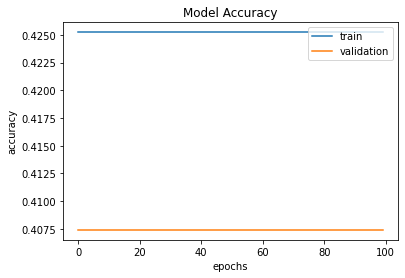

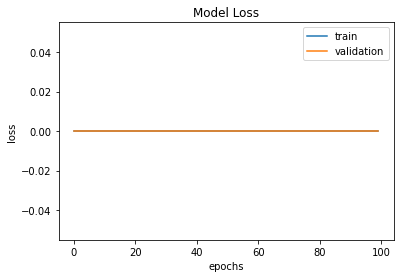

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
#Evaluate model's accuracy
test_loss, test_acc = model4.evaluate(X_te, y_te)

4/4 [==============================] - 12s 3s/step - loss: 0.0000e+00 - accuracy: 0.4074


The model instead of overfitting is underfitting and seems to be processing too many features. I will seek to reduce the number of nodes in the network.

The issue with the first epoch having a high value for the loss function still persists and then it keeps as per the workflow. Despite this behaviour, it seems the changes in optimizer were positive, as accuracy went up to 65%. 

The other issue I need to fix is the number of trainable parameters is extremely high (448 million) and is computationally inefficient. I will add another 2D CNN layer in order to reduce further the input shape of the flatten layer. 

<h2>7) Model Optimisation</h2>

Introducing a 3rd CNN layer and adding strides. I want to tweak how the model moves in terms of strides, meaning it will move 2 strides at a time through the convolution patches.

Also the model will include a fully connected network of 512 nodes.

In [ ]:
#Creating a 3D Convolutional Neural Network Model - aka Model2, and including strides as argument to reduce the number of parameters
visible = Input(shape=(480,480,3))
conv1 = Conv2D(32, kernel_size=5, strides = 2, activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=5, strides = 2, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=5, strides = 2, activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)
hidden1 = Dense(512, activation='relu')(flat)
hidden1 = Dropout(0.3)(hidden1)
output = Dense(1, activation='sigmoid')(hidden1)
model2 = Model(inputs=visible, outputs=output)
# summarize layers
print(model2.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 238, 238, 32)      2432      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 119, 119, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 58, 58, 64)        51264     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 29, 29, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 128)       2049

Adding a 3rd layer reduces considerably the number of trainable parameters from 448 million to 2.6 million. Next I will run the model again to observe the new model's performance.

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adam")
model2.compile(loss='binary_crossentropy',
optimizer=opt,
metrics=['accuracy'])

In [ ]:
#Training model 2 with 50 epochs
history = model2.fit(train_datagen.flow(X_tr, y_tr, batch_size = 64),
                    validation_data = test_datagen.flow(X_te, y_te, batch_size = 64),
                    steps_per_epoch= len(X_tr) / 64, 
                    validation_steps = len(X_te) /64,
                    epochs = 50, verbose = 1)

Epoch 1/50
6/6 [==============================] - 19s 3s/step - loss: 0.7571 - accuracy: 0.5257 - val_loss: 0.6847 - val_accuracy: 0.6019
Epoch 2/50
6/6 [==============================] - 19s 3s/step - loss: 0.6860 - accuracy: 0.5724 - val_loss: 0.6704 - val_accuracy: 0.6019
Epoch 3/50
6/6 [==============================] - 20s 3s/step - loss: 0.6875 - accuracy: 0.5724 - val_loss: 0.6748 - val_accuracy: 0.6019
Epoch 4/50
6/6 [==============================] - 19s 3s/step - loss: 0.6851 - accuracy: 0.5724 - val_loss: 0.6762 - val_accuracy: 0.6019
Epoch 5/50
6/6 [==============================] - 22s 3s/step - loss: 0.6810 - accuracy: 0.5724 - val_loss: 0.6649 - val_accuracy: 0.6019
Epoch 6/50
6/6 [==============================] - 19s 3s/step - loss: 0.6847 - accuracy: 0.5724 - val_loss: 0.6677 - val_accuracy: 0.6019
Epoch 7/50
6/6 [==============================] - 19s 3s/step - loss: 0.6820 - accuracy: 0.5724 - val_loss: 0.6613 - val_accuracy: 0.6019
Epoch 8/50
6/6 [==================

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

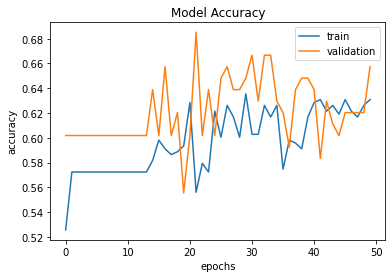

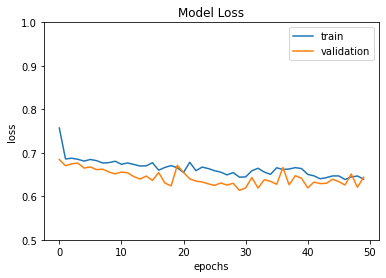

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.ylim([0.5, 1])
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
#Evaluate model's accuracy
test_loss, test_acc = model2.evaluate(X_te, y_te)

4/4 [==============================] - 1s 61ms/step - loss: 0.6438 - accuracy: 0.6574


Whilst I got a slight improvement, I still need to improve the model. I will now experiment with Batch Normalisation and including strides. 
I want to include Batch Normalisation to make sure that the dataset is normalized throughout the training process even when the mean and the variance can change significantly over time.

In [ ]:
#Creating a 3D Convolutional Neural Network Model - aka Model3, and including strides 
#as argument to reduce the number of parameters, also I included BatchNormalisation
visible = Input(shape=(480,480,3))
conv1 = Conv2D(32, kernel_size=5, strides = 2, use_bias=False)(visible)
conv1 = BatchNormalization()(conv1)
conv1 = Activation("relu")(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=5, strides = 2, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=5, strides = 2, activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)
hidden1 = Dense(512, activation='relu')(flat)
drop = Dropout(0.4)(hidden1)
output = Dense(1, activation='sigmoid')(hidden1)
model3 = Model(inputs=visible, outputs=output)
# summarize layers
print(model3.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 238, 238, 32)      2400      
                                                                 
 batch_normalization (BatchN  (None, 238, 238, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 119, 119, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 64)        5126

In [ ]:
#Configuring new model with tweaked learning rate and using Adam instead of RMSProp
model3.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

<h3>Introducting callbacks</h3>
I'm also introducing callbacks, which are useful when validation loss it's no longer improving, then they stop that learning and save the best performing run and restore the best weights.

In [ ]:
#Training model 3 with 50 epochs with callbacks
my_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)
history = model3.fit(train_datagen.flow(X_tr, y_tr, batch_size = 64),
                    validation_data = test_datagen.flow(X_te, y_te, batch_size = 64),
                    steps_per_epoch= len(X_tr) / 64, 
                    validation_steps = len(X_te) /64,
                    callbacks = my_callback,
                    epochs = 100, verbose = 1)


Epoch 1/100
6/6 [==============================] - 24s 3s/step - loss: 6.1839 - accuracy: 0.5234 - val_loss: 0.6862 - val_accuracy: 0.6667
Epoch 2/100
6/6 [==============================] - 22s 3s/step - loss: 0.6820 - accuracy: 0.5818 - val_loss: 0.6807 - val_accuracy: 0.6574


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

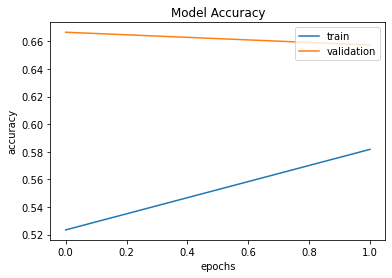

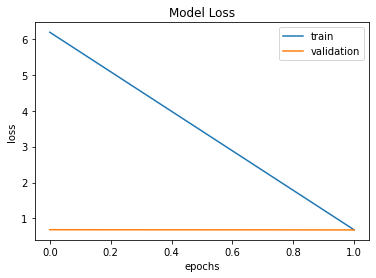

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
#Evaluate model's prediction
test_loss, test_acc = model3.evaluate(X_te, y_te)

4/4 [==============================] - 0s 46ms/step - loss: 0.6807 - accuracy: 0.6574


Whilst accuracy is similar as with previous runs (65%), the loss function chart hints at a non-existing learning curve. It seems callbacks is not useful for my model. I will now run the same model but without callbacks to observe the behaviour of the loss function.

In [ ]:
#Initialize model without callbacks
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adam")
model3.compile(loss='binary_crossentropy',
optimizer=opt,
metrics=['accuracy'])

In [ ]:
#Training model 3 with 50 epochs WITHOUT callbacks
history = model3.fit(train_datagen.flow(X_tr, y_tr, batch_size = 64),
                    validation_data = test_datagen.flow(X_te, y_te, batch_size = 64),
                    steps_per_epoch= len(X_tr) / 64, 
                    validation_steps = len(X_te) /64,
                    epochs = 50, verbose = 1)

Epoch 1/50
6/6 [==============================] - 27s 3s/step - loss: 2.8669 - accuracy: 0.5187 - val_loss: 0.6815 - val_accuracy: 0.6389
Epoch 2/50
6/6 [==============================] - 21s 3s/step - loss: 0.7145 - accuracy: 0.4743 - val_loss: 0.6880 - val_accuracy: 0.6389
Epoch 3/50
6/6 [==============================] - 21s 3s/step - loss: 0.6831 - accuracy: 0.5631 - val_loss: 0.6917 - val_accuracy: 0.6389
Epoch 4/50
6/6 [==============================] - 22s 3s/step - loss: 0.6820 - accuracy: 0.5818 - val_loss: 0.7030 - val_accuracy: 0.3611
Epoch 5/50
6/6 [==============================] - 22s 3s/step - loss: 0.6854 - accuracy: 0.5561 - val_loss: 0.6983 - val_accuracy: 0.3611
Epoch 6/50
6/6 [==============================] - 22s 3s/step - loss: 0.6757 - accuracy: 0.5841 - val_loss: 0.7063 - val_accuracy: 0.3611
Epoch 7/50
6/6 [==============================] - 22s 3s/step - loss: 0.6863 - accuracy: 0.5724 - val_loss: 0.7133 - val_accuracy: 0.3611
Epoch 8/50
6/6 [==================

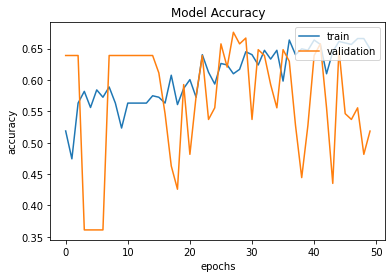

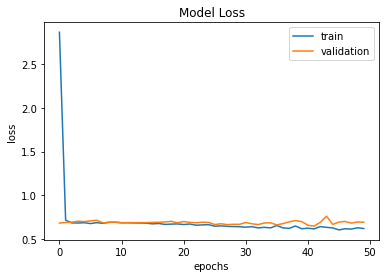

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
#Evaluate model's prediction
test_loss, test_acc = model3.evaluate(X_te, y_te)

4/4 [==============================] - 1s 119ms/step - loss: 0.6907 - accuracy: 0.5185


Both accuracy and loss function seem to have decreased in performance compared the previous run. I will experiment now changing back to RMSprop optimizer instead of Adam.

In [ ]:
#Configuring new model with tweaked learning rate and using Adam instead of RMSProp
model3.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [ ]:
#Training model 3 with 50 epochs WITHOUT callbacks
history = model3.fit(train_datagen.flow(X_tr, y_tr, batch_size = 64),
                    validation_data = test_datagen.flow(X_te, y_te, batch_size = 64),
                    steps_per_epoch= len(X_tr) / 64, 
                    validation_steps = len(X_te) /64,
                    epochs = 50, verbose = 1)

Epoch 1/50
6/6 [==============================] - 32s 5s/step - loss: 0.7807 - accuracy: 0.6028 - val_loss: 0.7228 - val_accuracy: 0.4167
Epoch 2/50
6/6 [==============================] - 20s 3s/step - loss: 0.7032 - accuracy: 0.5678 - val_loss: 0.6679 - val_accuracy: 0.6296
Epoch 3/50
6/6 [==============================] - 20s 3s/step - loss: 0.6451 - accuracy: 0.6449 - val_loss: 0.6744 - val_accuracy: 0.5556
Epoch 4/50
6/6 [==============================] - 21s 3s/step - loss: 0.6582 - accuracy: 0.6028 - val_loss: 0.6919 - val_accuracy: 0.5185
Epoch 5/50
6/6 [==============================] - 21s 3s/step - loss: 0.6553 - accuracy: 0.6192 - val_loss: 0.6795 - val_accuracy: 0.5648
Epoch 6/50
6/6 [==============================] - 21s 3s/step - loss: 0.6265 - accuracy: 0.6659 - val_loss: 0.8268 - val_accuracy: 0.4630
Epoch 7/50
6/6 [==============================] - 21s 3s/step - loss: 0.6475 - accuracy: 0.6495 - val_loss: 0.6806 - val_accuracy: 0.5556
Epoch 8/50
6/6 [==================

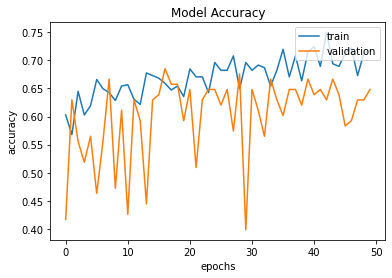

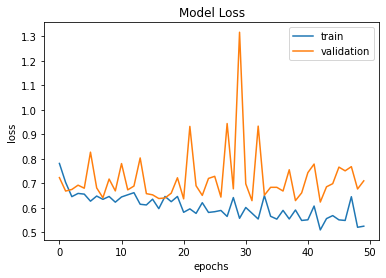

4/4 [==============================] - 0s 42ms/step - loss: 0.7097 - accuracy: 0.6481


In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
#Evaluate model's prediction
test_loss, test_acc = model3.evaluate(X_te, y_te)

In comparing both accuracy functions, it seems the model's accuracy is more robust when training rather than in validation. This could be because there is not enough randomness in the training data and it is better at predicting a fixed number of classes.

The marked split between validation and training hints towards a lack of generalisation of the model.

In [ ]:
#Creating a 3D Convolutional Neural Network Model - aka Model2, and including strides as argument to reduce the number of parameters
#I will tweak here the strides and set it to 2 meaning that it will 'hop' 2 pixels whilst moving through the image for a kernel size of 3x3.
#I am also introducing a batch normalization variable to make sure that the transformation maintains the mean output close to 0 
#and the output standard deviation close to 1.
visible = Input(shape=(480,480,3))
conv1 = Conv2D(32, kernel_size=(5,5), strides = 2, activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(5,5), strides = 2)(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation("relu")(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flat = Flatten()(pool2)
hidden1 = Dense(512, activation='relu')(flat)
hidden1 = Dropout(0.4)(hidden1)
output = Dense(1, activation='sigmoid')(hidden1)
model5 = Model(inputs=visible, outputs=output)
# summarize layers
print(model5.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 238, 238, 32)      2432      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 119, 119, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 58, 58, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 58, 58, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 58, 58, 64)        0   

In [ ]:
#Configuring new model with tweaked learning rate and using Adam instead of RMSProp
model5.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [ ]:
history = model5.fit(train_datagen.flow(X_tr, y_tr, batch_size = 32),
                    validation_data = test_datagen.flow(X_te, y_te, batch_size = 32),
                    steps_per_epoch= len(X_tr) / 32, 
                    validation_steps = len(X_te) /32,
                    epochs = 50, verbose = 1)

Epoch 1/50
13/13 [==============================] - 23s 2s/step - loss: 44.7520 - accuracy: 0.4860 - val_loss: 0.6914 - val_accuracy: 0.6574
Epoch 2/50
13/13 [==============================] - 22s 2s/step - loss: 0.8487 - accuracy: 0.5257 - val_loss: 0.6946 - val_accuracy: 0.3426
Epoch 3/50
13/13 [==============================] - 22s 2s/step - loss: 0.7240 - accuracy: 0.4860 - val_loss: 0.6911 - val_accuracy: 0.6574
Epoch 4/50
13/13 [==============================] - 22s 2s/step - loss: 0.6934 - accuracy: 0.5374 - val_loss: 0.6900 - val_accuracy: 0.6574
Epoch 5/50
13/13 [==============================] - 22s 2s/step - loss: 0.6966 - accuracy: 0.5257 - val_loss: 0.6863 - val_accuracy: 0.6574
Epoch 6/50
13/13 [==============================] - 22s 2s/step - loss: 0.8083 - accuracy: 0.5467 - val_loss: 0.6884 - val_accuracy: 0.6574
Epoch 7/50
13/13 [==============================] - 22s 2s/step - loss: 0.6950 - accuracy: 0.5350 - val_loss: 0.6847 - val_accuracy: 0.6574
Epoch 8/50
13/13 [=

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

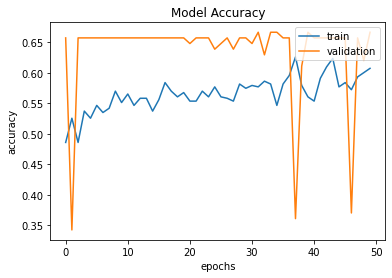

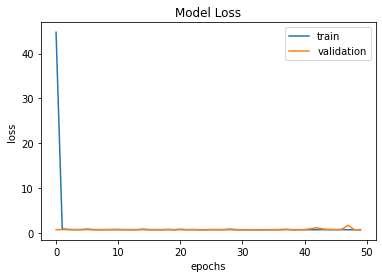

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
#Evaluate model's accuracy
test_loss, test_acc = model5.evaluate(X_te, y_te)

4/4 [==============================] - 0s 45ms/step - loss: 0.6308 - accuracy: 0.6667


In [ ]:
#Configuring new model with tweaked learning rate and using Adam instead of RMSProp
model2.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
#Training model 2 with 100 epochs
history = model2.fit(train_datagen.flow(X_tr, y_tr, batch_size = 64),
                    validation_data = test_datagen.flow(X_te, y_te, batch_size = 64),
                    steps_per_epoch= len(X_tr) / 64, 
                    validation_steps = len(X_te) /64,
                    epochs = 50, verbose = 1)

Epoch 1/50
6/6 [==============================] - 22s 3s/step - loss: 0.6135 - accuracy: 0.6402 - val_loss: 0.6863 - val_accuracy: 0.6296
Epoch 2/50
6/6 [==============================] - 22s 3s/step - loss: 0.5909 - accuracy: 0.6589 - val_loss: 0.6729 - val_accuracy: 0.6759
Epoch 3/50
6/6 [==============================] - 22s 3s/step - loss: 0.5617 - accuracy: 0.7173 - val_loss: 0.7892 - val_accuracy: 0.5556
Epoch 4/50
6/6 [==============================] - 22s 3s/step - loss: 0.5572 - accuracy: 0.6939 - val_loss: 0.8005 - val_accuracy: 0.6019
Epoch 5/50
6/6 [==============================] - 22s 3s/step - loss: 0.5724 - accuracy: 0.7009 - val_loss: 0.7848 - val_accuracy: 0.6111
Epoch 6/50
6/6 [==============================] - 21s 3s/step - loss: 0.6330 - accuracy: 0.6636 - val_loss: 0.6866 - val_accuracy: 0.5833
Epoch 7/50
6/6 [==============================] - 21s 3s/step - loss: 0.6002 - accuracy: 0.6729 - val_loss: 0.8127 - val_accuracy: 0.5093
Epoch 8/50
6/6 [==================

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

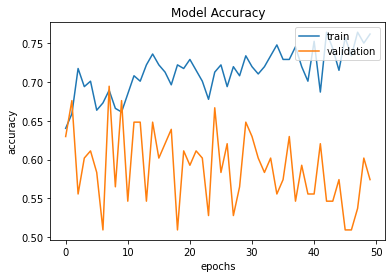

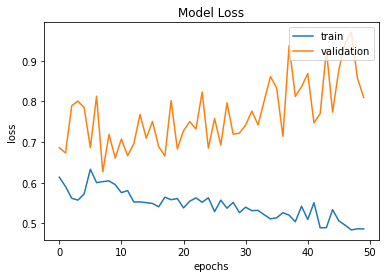

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

The loss function goes down whilst the validation function stays within the same range. Again, this could hint towards a lack of generalisation by the model.

In [ ]:
#Evaluate model's accuracy
test_loss, test_acc = model2.evaluate(X_te, y_te)

4/4 [==============================] - 0s 47ms/step - loss: 0.8096 - accuracy: 0.5741


In [ ]:
predictions = model2.predict(X_te)

<h2>Last Iteration</h2>

In [ ]:
#Iterated Model - Increasing density in first layer of fully connected network to get model to overfit
visible = Input(shape=(480,480,3))
conv1 = Conv2D(32, kernel_size=5, activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=5, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flat = Flatten()(pool2)
hidden1 = Dense(256, activation='relu')(flat)
hidden1 = Dropout(0.4)(hidden1)
output = Dense(1, activation='sigmoid')(hidden1)
model_6 = Model(inputs=visible, outputs=output)
# summarize layers
print(model_6.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 476, 476, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 238, 238, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 234, 234, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 117, 117, 64)     0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 876096)            0     

In [ ]:
#Configuring overfitting model as per above and replacing optimizer from RMSprop to Adam. 
#I shift to Adam because it is computationally efficient, has little memory requirement 
#(as per Keras documentation, available at https://keras.io/api/optimizers/adam/)
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adam")
model_6.compile(loss='binary_crossentropy',
optimizer=opt,
metrics=['accuracy'])

In [ ]:
#Iterated model with 50 epochs
history = model_6.fit(train_datagen.flow(X_tr, y_tr, batch_size = 64),
                    validation_data = test_datagen.flow(X_te, y_te, batch_size = 64),
                    steps_per_epoch= len(X_tr) / 64, 
                    validation_steps = len(X_te) /64,
                    epochs = 50, verbose = 1)

Epoch 1/50
6/6 [==============================] - 47s 4s/step - loss: 10.8268 - accuracy: 0.4813 - val_loss: 0.6599 - val_accuracy: 0.6389
Epoch 2/50
6/6 [==============================] - 24s 3s/step - loss: 0.7084 - accuracy: 0.5327 - val_loss: 0.6767 - val_accuracy: 0.6296
Epoch 3/50
6/6 [==============================] - 26s 4s/step - loss: 0.6934 - accuracy: 0.5537 - val_loss: 0.6909 - val_accuracy: 0.5463
Epoch 4/50
6/6 [==============================] - 24s 4s/step - loss: 0.6839 - accuracy: 0.5654 - val_loss: 0.6706 - val_accuracy: 0.6389
Epoch 5/50
6/6 [==============================] - 25s 4s/step - loss: 0.6802 - accuracy: 0.5631 - val_loss: 0.6904 - val_accuracy: 0.6389
Epoch 6/50
6/6 [==============================] - 24s 3s/step - loss: 0.6922 - accuracy: 0.5631 - val_loss: 0.6904 - val_accuracy: 0.6389
Epoch 7/50
6/6 [==============================] - 24s 3s/step - loss: 0.6913 - accuracy: 0.5631 - val_loss: 0.6882 - val_accuracy: 0.6389
Epoch 8/50
6/6 [=================

In [ ]:
history_dict = history.history

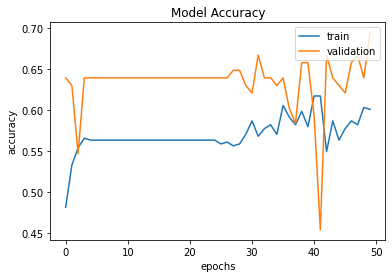

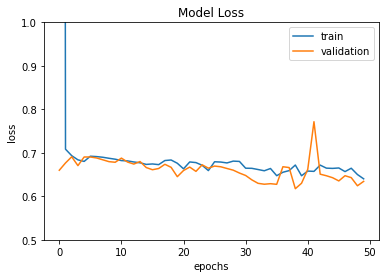

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.ylim([0.5, 1])
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
test_loss, test_acc = model_6.evaluate(X_te, y_te)

4/4 [==============================] - 5s 563ms/step - loss: 0.6344 - accuracy: 0.6944


This latest iteration of the model seems to be the best performing in terms of loss function decreasing over time and with analogous behaviour from the validation set (albeit 1 bump around 40 epochs mark). When the number of epochs is set to increase, the equivalent times that weights are changed in the neural network and the boundary goes from underfitting to optimal to overfitting. In this latest graph the model is still showing a high learning rate, because the loss function does not decrease much over time.

Conclusions:

*   The goal was to build a model that through  computer vision can establish if the image of a mushroom can be deemed edible or not
*   The available dataset consisted of 546 samples, so it was necessary to increase the sample size through data augmentation using ImageDataGenerator
*   Once data was pre-processed (mainly through padding and normalizing), I created a first model using functional API that consists of 2 hidden Conv layers and then 1 dense for a fully connected network with a final output of 1 dense layer since it is a binary classification problem (edible or not)
*   First, I generated a baseline model using DummyClassifier which achieved 59% of accuracy which is moderately better than tossing a coin every time a decision was made about a wild mushroom's edibility.
*   The first model showed many peaks and erratic performance when comparing training and validations's loss and accuracy, so the first changes I introduced was to increase the batch size and then the number of epochs.
*   Accuracy for the first model was slightly better than the baseline achieving 62%.
*   Having defined my baseline model, I turned to the next step in the universal workflow of machine learning which is to get a model to overfit. The first try resulted in an underfitting model, so after re-designing the number of layers, I achieved that by: adding a CNN layer, and adding more nodes to the  dense layer of 512 nodes before the output layer to interpret the results from the CNN, also setting the learning rate to 0.04, changing the optimizer from 'RMSprop' to 'Adam', keeping the number of epochs at 100.
*   Next I built more models with 3 hidden CNNs with different hyperparameters for example: adding batch normalization, callbacks (didn't work), reducing the number of trainable parameters, setting strides to 2 with a kernel size of 5. I observed a moderate increased in accuracy. Also I changed the optimizer from 'RMSprop' to 'Adamax' which is documented to perform better in binary problems.
*   The final result was a considerate improvement in accuracy from 59% (baseline) to 69%
*   One difficulty I encountered in terms of the universal workflow was that I couldn't get the model to overfit. This was because in order to increase the learning I should have increased the number of epochs from 100 to at least 1000, but unfortunately my Colab session was timing out after 3 hours or so, and just getting the model to run with 100 epochs took several attempts.
*   In order to mitigate this in the future, I considered the possibility of an enterprise solution such as Google Cloud Platform that can run GPU and TPU sessions that have more distributed and computing power. Since this is an academic project, I decided against that option, but would consider it in the future.
*   The best possible performance from the model was 69% of accuracy. This means that this model is not good enough for establishing edibility of a wild mushroom.
*   The way to further this project would be by increasing the sample size to at least 5000 samples so that the model can be more diverse and able to generalize with higher accuracy


<h2>Final thoughts</h2>
According to Yann Le Cun, a pioneer in machine learning, Computer vision models are the 'state-of-the-art' solution for image classification. With regards of mushroom identification, I consider Conv Neural Networks to be a very viable solution provided a good and diverse sample. CNN's goal is to learn to recognize and extract the important features in the input images. This translates smoothly to the mushroom classification task since edibility of a wild mushroom can be established by looking at the different physical components of a funghi such as colour, gills and cap. To further this aspect, it would be helpful to think not just of a balance between edible and not edible mushrooms in the dataset but also geo-location: if we are trying to train a model to identify mushrooms in England, it should consist of images taken in that country, as opposed to mushrooms in, say, Argentina where other varieties might be found and thus skew the dataset.













<h2>References:</h2>

Korhonen, J. Sienten tunnistaminen. Available at: https://www.funga.fi/teema-aiheet/sienten-tunnistaminen/  [Accessed 18 January 2022]

Chollet, F. Deep learning with Python. (Manning Publications, 2017) 1st edition.

Chollet, F. Classifier with little data, Github. Available at: https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d  [Accessed 18 January 2022]

Blog.keras.io. 2022. Building powerful image classification models using very little data. Available at: [link text](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)  [Accessed 5 February 2022].

Mushroom.world. 2022. Alphabetical list - Mushroom World. [online] Available at: <https://www.mushroom.world/mushrooms/namelist> [Accessed 30 January 2022].

Le Cun, Y., 2022. Yann LeCun: Dark Matter of Intelligence and Self-Supervised Learning | Lex Fridman Podcast. [online] Youtube.com. Available at: <https://www.youtube.com/watch?v=SGzMElJ11Cc&t=4859s> [Accessed 18 January 2022].

Ioffe, S., Szegedy, C. Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift (2015) Available at https://arxiv.org/abs/1502.03167  [Accessed 18 January 2022].

